In [1]:
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

In [2]:

# # Установка остальных пакетов
# %pip install ultralytics
# %pip install opencv-python==4.8.0.74
# %pip install wandb

In [3]:
import os
import sys
from pathlib import Path
import yaml
import torch
from ultralytics import YOLO

In [4]:
# Проверка доступности CUDA
print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA версия: {torch.version.cuda}")
    print(f"Количество GPU: {torch.cuda.device_count()}")
    print(f"Текущее GPU: {torch.cuda.get_device_name(0)}")
    print(f"Память GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("CUDA недоступна, будет использоваться CPU (тренировка будет медленнее)")

PyTorch версия: 2.5.1+cu121
CUDA доступна: True
CUDA версия: 12.1
Количество GPU: 1
Текущее GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Память GPU: 7.62 GB


In [5]:
# ---------------- БАЗОВАЯ НАСТРОЙКА ----------------
PROJECT_ROOT = Path("/home/gleb/Документы/33.VKR/mvp/road_monitoring").resolve()
os.chdir(PROJECT_ROOT)

os.environ['PYTHONIOENCODING'] = 'utf-8'
os.environ['LANG'] = 'ru_RU.UTF-8'
os.environ['LC_ALL'] = 'ru_RU.UTF-8'
if hasattr(sys.stdout, 'reconfigure'):
    sys.stdout.reconfigure(encoding='utf-8')
if hasattr(sys.stderr, 'reconfigure'):
    sys.stderr.reconfigure(encoding='utf-8')

print(f"Текущая директория: {os.getcwd()}")
print(f"Кодировка: {sys.stdout.encoding}")

TRAINING_DIR = PROJECT_ROOT / "training"
CFG_PATH     = TRAINING_DIR / "args.yaml"          # базовый конфиг
DATA_PATH    = TRAINING_DIR / "rdd_split.yaml"     # датасет
BEST_MODEL   = TRAINING_DIR / "runs" / "rdd_split" / "yolov8s2" / "weights" / "epoch40.pt"


Текущая директория: /home/gleb/Документы/33.VKR/mvp/road_monitoring
Кодировка: UTF-8


In [6]:
# ---------------- ЧТЕНИЕ И МОДИФИКАЦИЯ YAML ----------------
with open(CFG_PATH, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

# переопределяем только то, что нужно
cfg.update({
    "model": str(BEST_MODEL),                      # epoch40.pt
    "data": str(DATA_PATH),
    "epochs": 25,
    "patience": 18,
    "lr0": 0.0025,
    "warmup_epochs": 2,
    "cls": 0.8,
    "scale": 0.25,
    "device": 0 if torch.cuda.is_available() else "cpu",
    "project": str(TRAINING_DIR / "runs" / "rdd_split"),
    "name": "yolov8s_finetune",
})


print("\nИспользуемые ключевые параметры:")
for k in ["model", "data", "epochs", "lr0", "patience", "batch", "imgsz", "mosaic", "mixup", "copy_paste", "box", "cls", "dfl", "project", "name"]:
    print(f"{k}: {cfg[k]}")


Используемые ключевые параметры:
model: /home/gleb/Документы/33.VKR/mvp/road_monitoring/training/runs/rdd_split/yolov8s2/weights/epoch40.pt
data: /home/gleb/Документы/33.VKR/mvp/road_monitoring/training/rdd_split.yaml
epochs: 25
lr0: 0.0025
patience: 18
batch: 32
imgsz: 640
mosaic: 0.3
mixup: 0.1
copy_paste: 0.1
box: 7.5
cls: 0.8
dfl: 1.5
project: /home/gleb/Документы/33.VKR/mvp/road_monitoring/training/runs/rdd_split
name: yolov8s_finetune


In [7]:
# ---------------- ЗАПУСК ОБУЧЕНИЯ ----------------
device = cfg["device"]
print(f"\nИспользуемое устройство: {device}")
print("Автовзвешивание классов: включено (YOLOv8)\n")

model = YOLO(cfg["model"])

results = model.train(**cfg)

print(f"\nТРЕНИРОВКА ЗАВЕРШЕНА!")
print(f"Результаты: {cfg['project']}/{cfg['name']}")


Используемое устройство: 0
Автовзвешивание классов: включено (YOLOv8)

New https://pypi.org/project/ultralytics/8.4.9 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.4.8 🚀 Python-3.12.3 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7806MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=5, cls=0.8, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/home/gleb/Документы/33.VKR/mvp/road_monitoring/training/rdd_split.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0025, lrf=0.01,

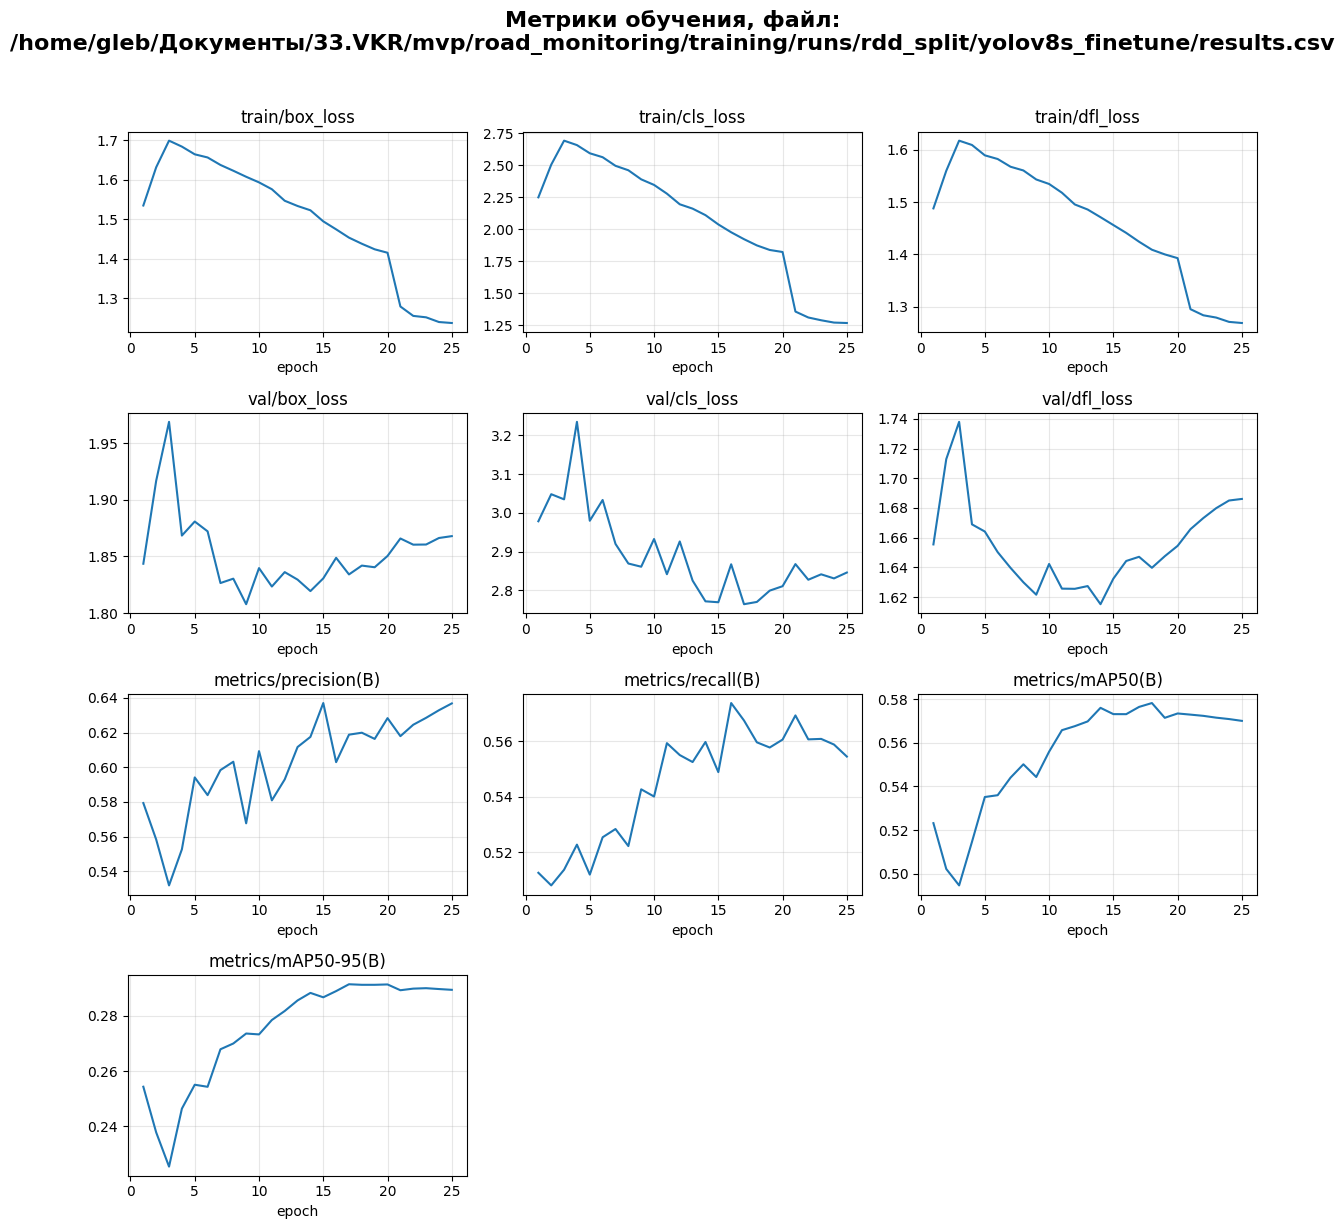

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

csv_path = TRAINING_DIR / "runs/rdd_split/yolov8s_finetune/results.csv"
# путь к CSV

df = pd.read_csv(csv_path)

# какие колонки рисовать
cols = [
    "train/box_loss",
    "train/cls_loss",
    "train/dfl_loss",
    "val/box_loss",
    "val/cls_loss",
    "val/dfl_loss",
    "metrics/precision(B)",
    "metrics/recall(B)",
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
]

fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.ravel()

fig.suptitle(f'Метрики обучения, файл:\n{csv_path}', fontsize=16, fontweight='bold', y=1.02)


for ax, col in zip(axes, cols):
    ax.plot(df["epoch"], df[col], label=col)
    ax.set_title(col, fontsize=12)
    ax.set_xlabel("epoch", fontsize=10)
    ax.grid(True, alpha=0.3)

# Скрываем лишние subplots (последние 2)
for ax in axes[len(cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from ultralytics import YOLO
from pathlib import Path

PROJECT_ROOT = Path("/home/gleb/Документы/33.VKR/mvp/road_monitoring").resolve()
TRAINING_DIR = PROJECT_ROOT / "training"

model_path = TRAINING_DIR / "runs/rdd_split/yolov8s_finetune/weights/best.pt"
data_path  = TRAINING_DIR / "rdd_split.yaml"

model = YOLO(model_path)

metrics = model.val(
    data=str(data_path),
    split="test",        # важное место
    imgsz=640,
    batch=32,
    device=0,
    save_json=True,
    project=str(TRAINING_DIR / "runs/test_eval"),
    name="yolov8s_finetune_test",
)

print('mAP@0.5-0.95 {metrics.box.map}')       # mAP@0.5-0.95
print(f'mAP@0.5 {metrics.box.map50}')    # mAP@0.5
print(f'per-class AP {metrics.box.maps}')     # per-class AP

Ultralytics 8.4.8 🚀 Python-3.12.3 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7806MiB)
Model summary (fused): 73 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1646.3±1158.7 MB/s, size: 462.4 KB)
val: Scanning /home/gleb/Документы/33.VKR/mvp/road_monitoring/training/datasets/RDD_SPLIT/test/labels... 5076 images, 1790 backgrounds, 496 corrupt: 100% ━━━━━━━━━━━━ 5076/5076 5.1Kit/s 1.0s0.1s
val: /home/gleb/Документы/33.VKR/mvp/road_monitoring/training/datasets/RDD_SPLIT/test/images/Czech_000010.jpg: ignoring corrupt image/label: Label class 4 exceeds dataset class count 4. Possible class labels are 0-3
val: /home/gleb/Документы/33.VKR/mvp/road_monitoring/training/datasets/RDD_SPLIT/test/images/Czech_000275.jpg: ignoring corrupt image/label: Label class 4 exceeds dataset class count 4. Possible class labels are 0-3
val: /home/gleb/Документы/33.VKR/mvp/road_monitoring/training/datasets/RDD_SPLIT/test/images/Czech_0